In [1]:
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, MaxPooling2D
from keras.layers.convolutional import Convolution2D



Using TensorFlow backend.


## Things to try
- New NN architecture

    - 

### Done
- Try Comma AI model
- Try Nvidia Model
- Augment data with left and right images

- Preprocess input
    - Black and White: tried it, did not produce better results

In [2]:
def get_commaai_model(img_shape):

    row, col, ch = img_shape  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode='same', activation='elu'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='same', activation='elu'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode='same', activation='elu'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Dense(512, activation='elu'))
    model.add(Dropout(.5))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model

In [3]:
def get_nvidia_model(img_shape, keep_prob = 0.6):

    row, col, ch = img_shape  # camera format
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation='elu'))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [4]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split

In [5]:

# Parameters
batch_size = 256
resize_shape = (66, 200, 3)

keep_prob = 0.6

epochs = 10
near_0_sampling_prob = 0.6
near_0_threshold = 0.03

root_dir = 'data'

# Read Data
df = pd.read_csv( root_dir + '/driving_log.csv', sep=',')

X = df[['center', 'left', 'right']].values
y = df['steering'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

sample_multiplier = 20
samples_per_epoch = int(sample_multiplier * X_train.shape[0] / batch_size) * batch_size



In [6]:
def random_shadow(image):

    height, width, ch = image.shape
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = width * np.random.rand(), 0
    x2, y2 = width * np.random.rand(), height
    xm, ym = np.mgrid[0:height, 0:width]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def random_translate(image, angle, range_x=100, range_y=10):
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, angle


def random_flip(img, angle):
    
    # Add horizontal flip
    ind_flip = np.random.randint(2)
    if ind_flip == 0:    
        img = np.fliplr(img)
        angle = -angle
        
    return img, angle


def preprocess(img, angle):
    
    #Crop
    img = img[60:-25, :, :]
    #Resize
    img = cv2.resize(img, (resize_shape[1], resize_shape[0]), cv2.INTER_AREA)
    
    # Add shadow
    img = random_shadow(img)
    #Change color
    img = random_brightness(img)
    # Translate
    img, angle = random_translate(img, angle, 100, 10)
    # Random flip
    img, angle = random_flip(img, angle)
    
    return img, angle

def preprocessed_random_image(row, angle, root_dir):
    
    angles = [0, 1, 2]
    angle_offset = [0, 0.25, -0.25]
    
    j = random.choice(angles)
    angle = float(angle) + angle_offset[j]

    # If left or right image does not exist, return center
    if not row[j] or type(row[j]) is float:
        j = 0

    img_path = root_dir + '/' + row[j].strip()
    img = cv2.imread(img_path)

    img, angle = preprocess(img, angle)
    
    return img, angle
    

def gen_batches(X, y, batch_size=256, training=True):

    ## Generator for keras training, with subsampling  

    while True:
        batch_images = []
        batch_angles = []
        for i_batch in range(batch_size):
            
            selected = False
            while not selected:
                i_row = np.random.randint(X.shape[0])
                row = X[i_row]
                angle = y[i_row]

                img, angle = preprocessed_random_image(row, angle, './' + root_dir)
                
                if np.random.rand() < near_0_sampling_prob and angle < near_0_threshold and training:
                    continue
                else:
                    selected = True
                    


            batch_images.append(img)
            batch_angles.append(angle)        
            
        batch_images = np.asarray(batch_images)
        batch_angles = np.asarray(batch_angles)
        yield batch_images, batch_angles

In [ ]:

# def get_data(log_file):
    
#     angles = [0, 1, 2]
#     angle_offset = [0, 0.2, -0.2]
    
#     # Read log file and get root directory
#     df = pd.read_csv(log_file, sep=',')
#     root_dir = '/'.join(log_file.split('/')[:-1])
    
#     features = []
#     labels = []
    
#     for i, row in df.iterrows():
        
#         img, angle = preprocessed_random_image(row, root_dir)

#         features.append(img)
#         labels.append(angle)         
    
#     features = np.asarray(features)
#     labels = np.asarray(labels)
#     return features, labels

# features, labels = get_data('data/driving_log.csv')
# print(features.shape)
# print('Done')


In [ ]:
# data = {
#     'features': features,
#     'labels': labels
# }
# with open('data.p', 'w') as f:
#     pickle.dump(data, f)

0.3976445 (160, 320, 3)


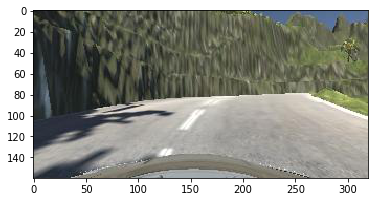

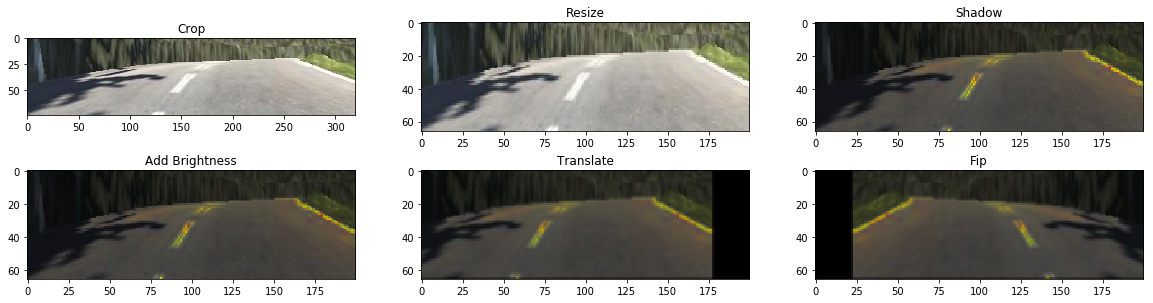

In [7]:
i = random.randint(0, X.shape[0])

img_path = root_dir + '/' + X[i][0]
img = cv2.imread(img_path)
angle = y[i]


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(angle, img.shape)
plt.imshow(img)
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))

#Crop
img = img[60:-25, :, :]
axes[0][0].imshow(img)
axes[0][0].set_title('Crop')
#Resize
img = cv2.resize(img, (resize_shape[1], resize_shape[0]), cv2.INTER_AREA)
axes[0][1].imshow(img)
axes[0][1].set_title('Resize')
# Add shadow
img = random_shadow(img)
axes[0][2].imshow(img)
axes[0][2].set_title('Shadow')
#Change color
img = random_brightness(img)
axes[1][0].imshow(img)
axes[1][0].set_title('Add Brightness')
# Translate
img, angle = random_translate(img, angle, 100, 10)
axes[1][1].imshow(img)
axes[1][1].set_title('Translate')
# Random flip
img, angle = random_flip(img, angle)
axes[1][2].imshow(img)
axes[1][2].set_title('Fip')

plt.show()

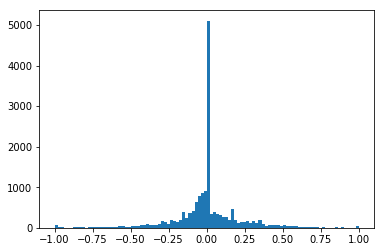

In [8]:
plt.hist(y, bins=100)
plt.show()

In [ ]:

model = get_commaai_model(resize_shape)
training_generator = gen_batches(X_train, y_train, batch_size=batch_size, training=True)
validation_generator = gen_batches(X_val, y_val, batch_size=batch_size, training=False)
history = model.fit_generator(training_generator, 
                                     nb_epoch=epochs, 
                                     samples_per_epoch=samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=X_val.shape[0],
                                     verbose = 1
                                    
                                    )


model.save('comma_model.h5')

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
model = get_nvidia_model(resize_shape, keep_prob)
training_generator = gen_batches(X_train, y_train, batch_size=batch_size, training=True)
validation_generator = gen_batches(X_val, y_val, batch_size=batch_size, training=False)
history = model.fit_generator(training_generator, 
                                     nb_epoch=epochs, 
                                     samples_per_epoch=samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=X_val.shape[0],
                                     verbose = 1
                                    
                                    )


model.save('nvidia_model.h5')

Epoch 1/10
 43520/302080 [===>..........................] - ETA: 1436s - loss: 0.1165

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
